# Bootstrapping Yield Curve from T-Bonds

## Loading Data

In [1]:
#Importing all the necessary libraries

import numpy as np
import pandas as pd
from datetime import date
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

import datetime
import collections
import requests
from bs4 import BeautifulSoup
import json

In [2]:
#defining a custom function to scrape required data from https://www.wsj.com/market-data/bonds/treasuries

def scrape_data():
    #The function is specifically written for scraping treasury notes prices
    #data from wsj.com website
    mostActiveStocksUrl = "https://www.wsj.com/market-data/bonds/treasuries"
    page = requests.get(mostActiveStocksUrl, headers={'User-Agent': 'Custom'})
    data = page.text
    soup = BeautifulSoup(page.content, 'html.parser')
    rows = soup.find_all('script') # we get all the script tags
    importantJson = ''

    for r in rows:
        text = r.text
        if 'mdc_treasury_' in text: # the scirpt tags containing the date,
            importantJson = text
            break

    importantJson = importantJson\
        .replace('window.__STATE__ =', '')\
        .replace(';', '')\
        .strip()

    jsn = json.loads(importantJson)
    df_data = pd.json_normalize(jsn['data']['mdc_treasury_{\"treasury\":\"NOTES_AND_BONDS\"}']['data']['data']['instruments'])
    
    #re-order the columns of the extracted data to match the order of data
    #reflected in the website
    cols = ['maturityDate','coupon','bid','ask','change','askYield']
    df_data = df_data[cols]
    
    #Change the names of the columns of the extracted data to match the names that are 
    #reflected in the website
    df_data.columns = ['MATURITY','COUPON', 'BID', 'ASKED', 'CHG', 'ASKED YIELD']
    
    #filter data to remove NA values
    df_data = df_data[df_data['BID'] != "n.a."]
    
    #Change the type of variables of Maturity date to pandas datetime and coupon, bid and asked
    #price to numeric
    df_data['MATURITY'] = pd.to_datetime(df_data['MATURITY'].astype(str))
    df_data[['COUPON', 'BID', 'ASKED']] = df_data[['COUPON', 'BID', 'ASKED']].apply(pd.to_numeric)
    df_data = df_data[df_data['BID'] != 0]
    #df_data.set_index("maturityDate", inplace=True)
    #df_data.index = pd.to_datetime(df_data.index, format = '%m/%d/%Y').strftime('%Y-%m-%d')
    return df_data

In [3]:
#Running the scrape_data() function created above and storing the data in a variable
TBond_data = scrape_data()

In [4]:
#Back-up of copying the data to python through csv files in case web scraping doesn't work

#TBond_data = pd.read_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/WSJ T-Bond Data.csv")
#TBond_data['MATURITY'] = pd.to_datetime(TBond_data['MATURITY'].astype(str))
#TBond_data = TBond_data[TBond_data['MATURITY'].dt.day == 15] 

In [5]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
0,2020-09-30,1.375,100.014,100.020,unch.,-0.3816
1,2020-09-30,2.000,100.020,100.024,-0.0020,-0.1974
2,2020-09-30,2.750,100.024,100.030,-0.0060,0.1091
3,2020-10-15,1.625,100.032,100.036,-0.0020,0.093
4,2020-10-31,1.375,100.044,100.050,-0.0060,0.068


In [6]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD
308,2049-08-15,2.250,119.096,119.116,-0.1660,1.430
309,2049-11-15,2.375,122.152,122.172,-0.1540,1.427
310,2050-02-15,2.000,113.150,113.170,-0.8540,1.434
311,2050-05-15,1.250,95.046,95.066,-0.1600,1.449
312,2050-08-15,1.375,98.062,98.082,-0.1620,1.447


## Computing Accrued Interest

In [7]:
#Getting today's date
#Also get the spot settlement day by T+1 adjustment
spot_conv = 1 #2 for some markets
date0 = date.today()
date0 = pd.to_datetime(date0)
settle_date = date0 + pd.Timedelta(days = spot_conv)

In [8]:
#Defining a custom function that returns the coupon payment dates of a 30 Year bond based on the maturity date of the bond
def cpn_schedule(maturity):
    #construct the past 60 coupon payment dates from the maturity date of the bond
    cpn_dates = np.empty(61, dtype=object)    
    for i in range(1,62):
        if(maturity.day == 15):
            cpn_dates[-i] = maturity + relativedelta(months=-(i-1)*6)
        else:    
            #forcing the coupon payment dates to month-end dates
            cpn_dates[-i] = maturity + relativedelta(months=-(i-1)*6) + relativedelta(day=31)    
    return cpn_dates 

In [9]:
#Defining a custom function that calculates Accrued Interest from the coupon rate, today's date and the maturity date of the bond
def Accr_Int(cpn, date0, maturity):
    #Create the coupon payment schedule from the maturity date of bond
    cpn_schd = cpn_schedule(maturity)
    #if valuation date coincides with maturity of the bonds
    if (date0 == maturity):
        return 0.5 * cpn
    #if coupon payment date matches the date of valuation
    elif (cpn_schd[np.searchsorted(cpn_schd, date0)] == date0):
        prev_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0)]
        next_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0) + 1]
    #if valuation date lies between coupon payment dates
    else:
        prev_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0) - 1]
        next_cpn_date = cpn_schd[np.searchsorted(cpn_schd, date0)]
    
    acc_int = 0.5 * cpn * (date0 - prev_cpn_date)/(next_cpn_date - prev_cpn_date)
    
    return acc_int

In [10]:
#Creating a column in the dataframe for accrued interest and populating it by running the custom function defined bove
TBond_data['ACCR_INT'] = np.nan

for i in range(len(TBond_data)):
    TBond_data.iloc[i,6] = Accr_Int(TBond_data.iloc[i,1], date0 + pd.Timedelta(days=spot_conv), TBond_data.iloc[i,0])

In [11]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT
0,2020-09-30,1.375,100.014,100.020,unch.,-0.3816,0.646175
1,2020-09-30,2.000,100.020,100.024,-0.0020,-0.1974,0.939891
2,2020-09-30,2.750,100.024,100.030,-0.0060,0.1091,1.292350
3,2020-10-15,1.625,100.032,100.036,-0.0020,0.093,0.697063
4,2020-10-31,1.375,100.044,100.050,-0.0060,0.068,0.530571


## Computing Dirty Price

In [12]:
# Dirty Price = Clean Price + Accrued Interest
TBond_data['DIRTY_PRICE'] = TBond_data['ASKED'] + TBond_data['ACCR_INT']

In [13]:
TBond_data.head()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT,DIRTY_PRICE
0,2020-09-30,1.375,100.014,100.020,unch.,-0.3816,0.646175,100.666175
1,2020-09-30,2.000,100.020,100.024,-0.0020,-0.1974,0.939891,100.963891
2,2020-09-30,2.750,100.024,100.030,-0.0060,0.1091,1.292350,101.322350
3,2020-10-15,1.625,100.032,100.036,-0.0020,0.093,0.697063,100.733063
4,2020-10-31,1.375,100.044,100.050,-0.0060,0.068,0.530571,100.580571


In [14]:
TBond_data.tail()

,MATURITY,COUPON,BID,ASKED,CHG,ASKED YIELD,ACCR_INT,DIRTY_PRICE
308,2049-08-15,2.250,119.096,119.116,-0.1660,1.430,0.213995,119.329995
309,2049-11-15,2.375,122.152,122.172,-0.1540,1.427,0.819633,122.991633
310,2050-02-15,2.000,113.150,113.170,-0.8540,1.434,0.190217,113.360217
311,2050-05-15,1.250,95.046,95.066,-0.1600,1.449,0.431386,95.497386
312,2050-08-15,1.375,98.062,98.082,-0.1620,1.447,0.130774,98.212774


## Matrix Formulations

In [15]:
#Creating an list of all the dates on which cashflows will occur 
#if we hold a portfolio consisting of one of all the bonds listed in the data

Alldates = np.empty(0)

for i in range(len(TBond_data)):
    Alldates = np.hstack((Alldates, cpn_schedule(TBond_data.iloc[i,0])))
    
#Filter out the dates that are older than the valuation date as these dates
#are not required for valuation
Alldates = np.unique(Alldates)
Alldates = Alldates[date0 < Alldates]

## Creation of a Price Matrix

In [16]:
#Remove all the columns not needed for computation of the discount rates
TBond_data_f = TBond_data.drop(['BID','ASKED','CHG','ASKED YIELD','ACCR_INT'], axis = 1)
#Add a column to the filtered dataframe representing the Principal value of the bond
TBond_data_f['PRINCIPAL'] = 100

In [17]:
#Aggregate the price, coupon and Principal data for bonds maturing on the same date
#to create an aggregate security capturing all the discount factors that are reflected
#by the bonds maturity on that particular maturity date
Agg_Bond_data = TBond_data_f.groupby([TBond_data_f['MATURITY'].dt.date]).sum()

In [18]:
#Store the values in Price_matrix
Price_matrix = Agg_Bond_data

In [19]:
Price_matrix.head()

,COUPON,DIRTY_PRICE,PRINCIPAL
MATURITY,,,
2020-09-30,6.125,302.952415,300
2020-10-15,1.625,100.733063,100
2020-10-31,6.000,302.537217,300
2020-11-15,4.375,201.725851,200
2020-11-30,6.375,302.333402,300


In [20]:
Price_matrix.tail()

,COUPON,DIRTY_PRICE,PRINCIPAL
MATURITY,,,
2049-08-15,2.250,119.329995,100
2049-11-15,2.375,122.991633,100
2050-02-15,2.000,113.360217,100
2050-05-15,1.250,95.497386,100
2050-08-15,1.375,98.212774,100


## Generating the CF matrix

In [21]:
#Create a matrix of all the dates when cashflows occur
#for all the bonds present in the WSJ data
CF = pd.DataFrame(columns=Alldates)
CF = CF.T
CF.head()

""
2020-09-30
2020-10-15
2020-10-31
2020-11-15
2020-11-30


In [22]:
for i in range(len(Price_matrix)):
    #generate coupon payment schedule for all the bonds in Price matrix iteratively 
    #and fill the Cashflows matrix with cashflows of all the bonds
    cpn_dates = cpn_schedule(Price_matrix.iloc[i,:].name)[settle_date <= cpn_schedule(Price_matrix.iloc[i,:].name)].astype("datetime64[ns]")

    cpns = np.empty(len(cpn_dates)); cpns.fill(0.5*Price_matrix.iloc[i,:].COUPON)
    cpns[-1] = cpns[-1] + Price_matrix.iloc[i,:].PRINCIPAL
    
    cpn_pmts = pd.DataFrame(cpns, index = cpn_dates)
    CF = pd.concat([CF,cpn_pmts], axis=1)

In [23]:
CF.head(20)

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-09-30,303.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-15,NaN,100.8125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-31,NaN,NaN,303.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-15,NaN,NaN,NaN,202.1875,NaN,NaN,NaN,NaN,NaN,NaN,...,1.5625,NaN,1.6875,NaN,1.4375,NaN,1.1875,NaN,0.625,NaN
2020-11-30,NaN,NaN,NaN,NaN,303.1875,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-15,NaN,NaN,NaN,NaN,NaN,100.9375,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31,NaN,NaN,NaN,NaN,NaN,NaN,303.3125,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.875,...,NaN,1.5,NaN,1.5,NaN,1.125,NaN,1.0,NaN,0.6875


In [24]:
CF = CF.T
CF = CF.fillna(0)

In [25]:
CF.head(20)

,2020-09-30,2020-10-15,2020-10-31,2020-11-15,2020-11-30,2020-12-15,2020-12-31,2021-01-15,2021-01-31,2021-02-15,...,2048-05-15,2048-08-15,2048-11-15,2049-02-15,2049-05-15,2049-08-15,2049-11-15,2050-02-15,2050-05-15,2050-08-15
0,303.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,303.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,202.1875,0.0000,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,303.1875,0.0000,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,100.9375,0.0000,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,303.3125,0.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,101.0000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,303.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,306.875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
CF.shape

(201, 228)

## Computing the discounting factor matrix

In [27]:
#d = np.matmul(np.linalg.inv(CF.values),Price_matrix['DIRTY_PRICE'].values)

In [28]:
#Compute the vector of discount factors by matrix multiplication of 
#pseudo inverse of the Cashflows matrix and Dirty prices of the bonds
d = np.matmul(np.linalg.pinv(CF),Price_matrix['DIRTY_PRICE'].values)

#from scipy.optimize import nnls 
#d,rnorm = nnls(CF, Price_matrix['DIRTY_PRICE'].values)

In [29]:
#Discount Factors
d

array([0.99963676, 0.99921203, 0.99847266, 0.99771673, 0.99718294,
       0.99701105, 0.99580538, 0.99565045, 0.99502052, 0.99648308,
       0.99647549, 0.99880166, 0.99696379, 0.99747716, 0.99568186,
       0.99524732, 0.99568548, 0.99351953, 0.99570904, 0.99873162,
       0.99426925, 0.9958867 , 0.99431019, 0.99481168, 0.99759674,
       0.992365  , 0.99667222, 0.99779423, 0.99476167, 0.99792181,
       0.9942122 , 0.99748535, 0.99390101, 0.99502179, 0.99520527,
       0.99580311, 0.99458737, 0.99584156, 0.99246778, 0.99458843,
       0.99173992, 0.99229859, 0.99226815, 0.99128599, 0.99375198,
       0.99328334, 0.99233184, 0.99260062, 0.99460578, 0.99343222,
       0.99182971, 0.9964082 , 0.99660582, 0.99489517, 0.99351502,
       0.99584771, 0.99327692, 0.99204619, 0.9954109 , 0.9904441 ,
       0.99184654, 0.99446641, 0.99080851, 0.99211289, 0.99291943,
       0.99401366, 0.99179909, 0.98941393, 0.99396554, 0.99057981,
       0.9914664 , 0.98912782, 0.99234577, 0.99194593, 0.99410

In [30]:
#Convert the discount factors into annualized continuous interest rates
mat_times = (CF.columns - settle_date).days/365.25
d_mod = -1*np.log(d)/mat_times

In [31]:
#Construct a dataframe with dates and discount rates
disc_rates = pd.DataFrame(d_mod, index = CF.columns, columns = (['Rates']))
disc_rates.replace([np.inf, -np.inf], np.nan)

,Rates
2020-09-30,0.012063
2020-10-15,0.011074
2020-10-31,0.013293
2020-11-15,0.014648
2020-11-30,0.014311
...,...
2049-08-15,0.012666
2049-11-15,0.011825
2050-02-15,0.012992
2050-05-15,0.013193


## Plot Maturity Date vs Discount Rates

Text(0, 0.5, 'Discount rate')

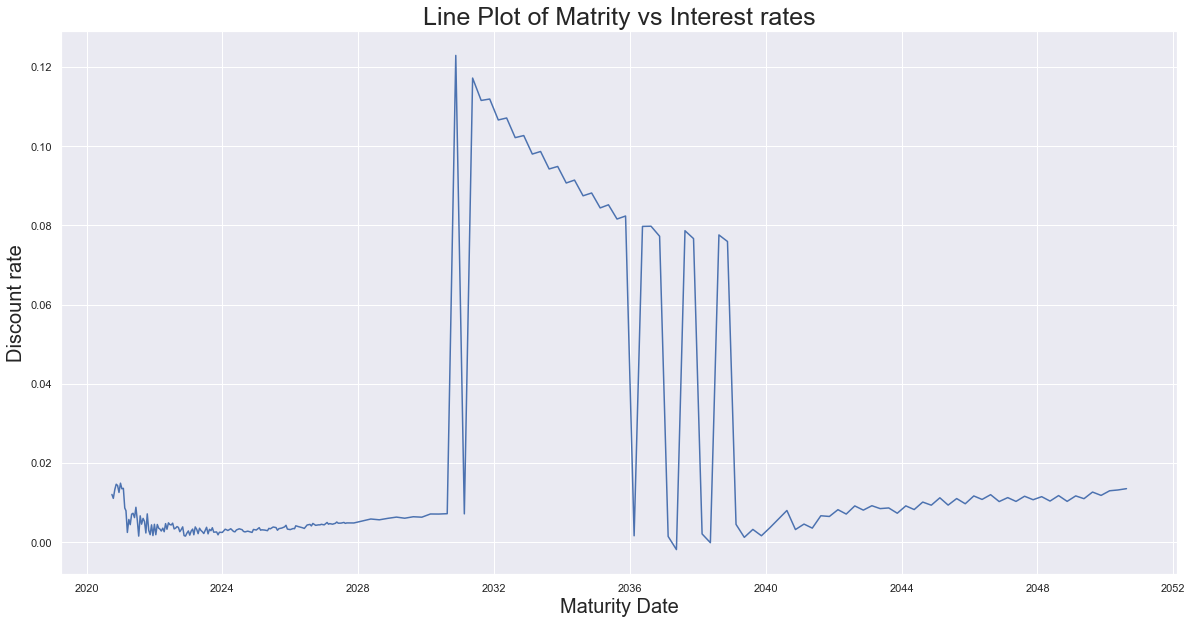

In [32]:
#Line plot of dates vs discount rates
plt.figure(figsize=(20,10))
plt.plot(disc_rates.index,disc_rates.Rates)
plt.title('Line Plot of Matrity vs Interest rates', fontsize = 25)
plt.xlabel('Maturity Date', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)

Text(0, 0.5, 'Discount rate')

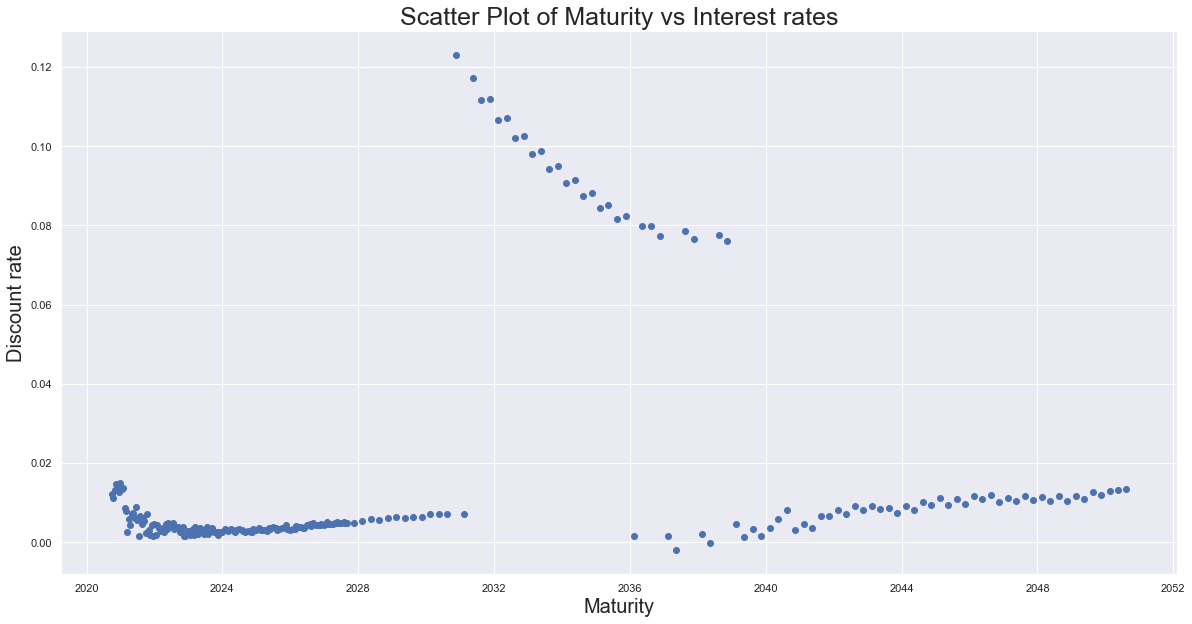

In [33]:
#Scatter plot of dates vs discount rates
plt.figure(figsize=(20,10))
plt.scatter(disc_rates.index,disc_rates.Rates)
plt.title('Scatter Plot of Maturity vs Interest rates', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)

(-0.005, 0.02)

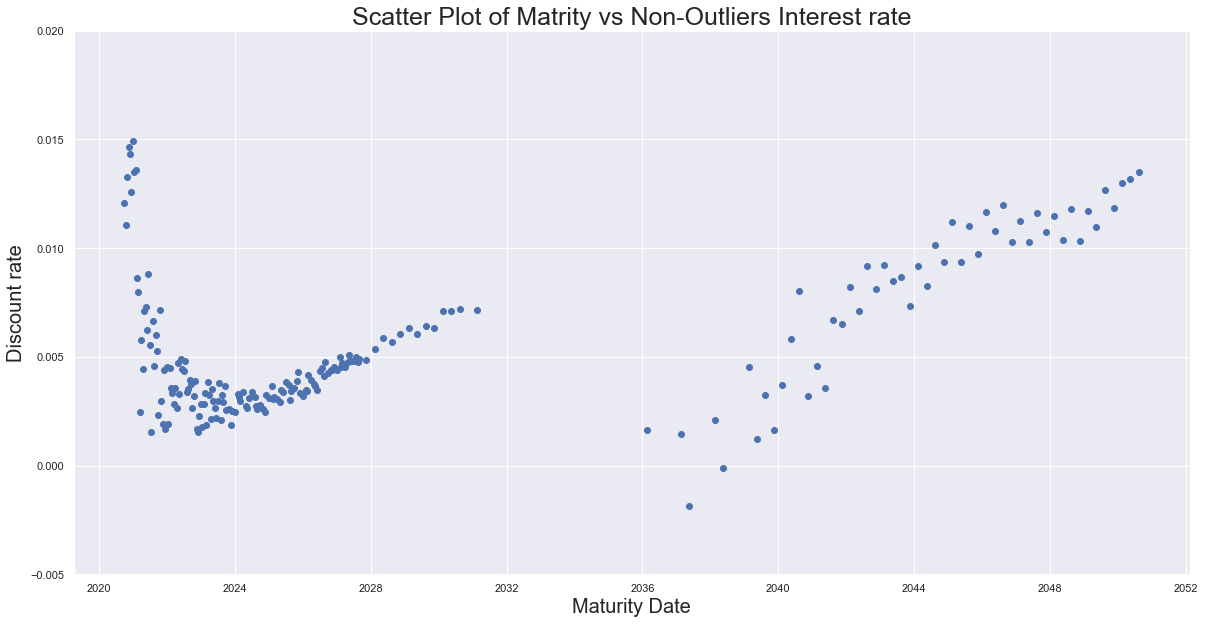

In [34]:
#Scatter plot of dates vs discount rates: zoomed in 
plt.figure(figsize=(20,10))
plt.scatter(disc_rates.index,disc_rates.Rates)
plt.title('Scatter Plot of Matrity vs Non-Outliers Interest rate', fontsize = 25)
plt.xlabel('Maturity Date', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.ylim(-0.005,0.02)

## Removing Outliers

In [35]:
#Filtering outliers in the discount rates calculated
disc_rates_f = disc_rates[disc_rates.Rates < 0.06]
disc_rates_f['Mat_Time'] = (disc_rates_f.index - date0).days/365.25

C:\Users\bhask\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Fitting a smooth curve through the spine using Spline and Gaussian Filter

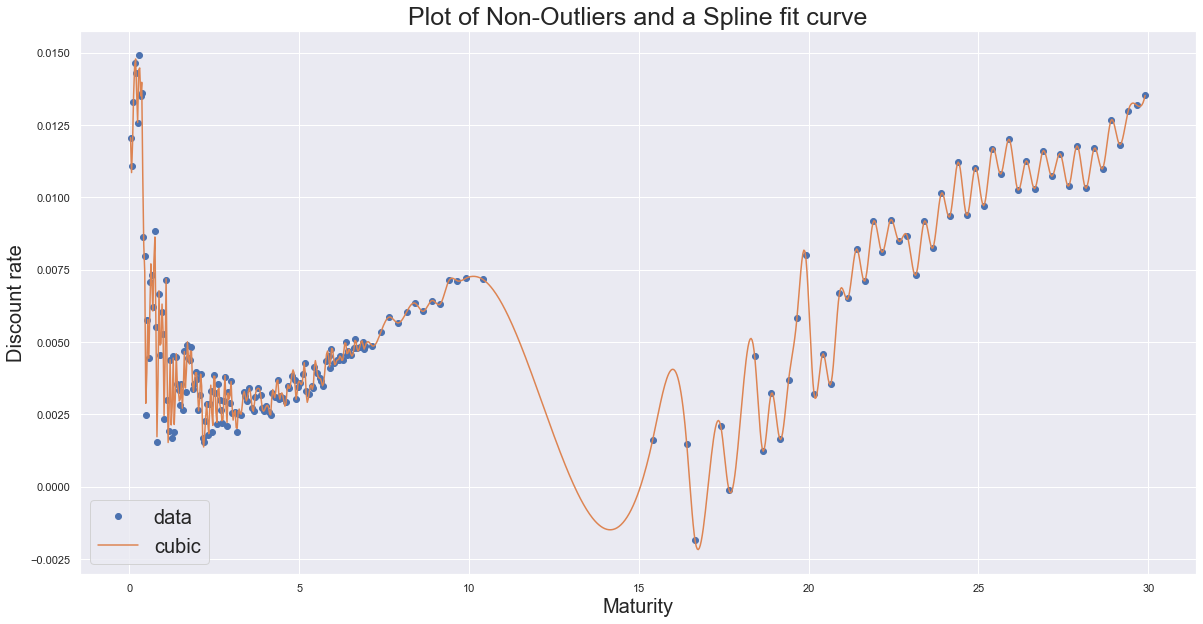

In [36]:
#Using cubic spline to fit a curve through the filtered data points
from scipy.interpolate import interp1d
fit = 'cubic'
f = interp1d(disc_rates_f.Mat_Time, disc_rates_f.Rates, kind = fit)
mat_times_granular = np.linspace(disc_rates_f.Mat_Time.min(), disc_rates_f.Mat_Time.max(), num=1000, endpoint=True)

plt.figure(figsize=(20,10))
plt.title('Plot of Non-Outliers and a Spline fit curve', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.plot(disc_rates_f.Mat_Time, disc_rates_f.Rates , 'o', mat_times_granular, f(mat_times_granular), '-')
plt.legend(['data', fit], loc='best', prop={'size': 20})


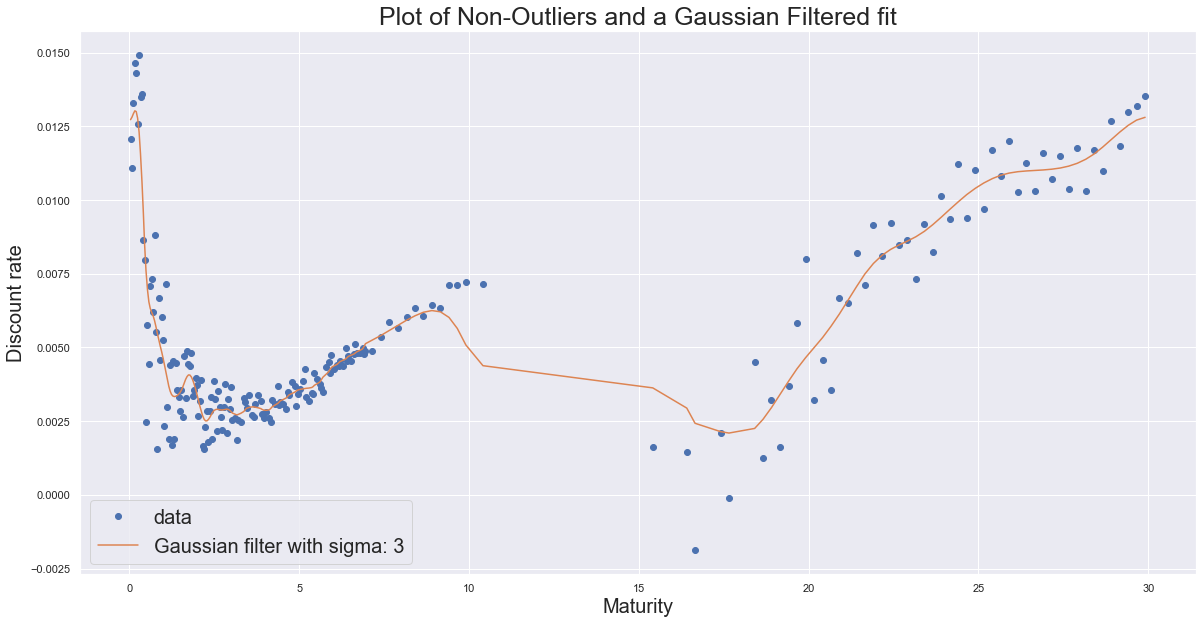

In [37]:
#Using cubic spline to fit a gaussian filter plot through the filtered data points
from scipy.ndimage.filters import gaussian_filter1d
sig = 3
rates_smoothg = gaussian_filter1d(disc_rates_f.Rates, sigma = sig)

plt.figure(figsize=(20,10))
plt.title('Plot of Non-Outliers and a Gaussian Filtered fit', fontsize = 25)
plt.xlabel('Maturity', fontsize = 20)
plt.ylabel('Discount rate', fontsize = 20)
plt.plot(disc_rates_f.Mat_Time, disc_rates_f.Rates , 'o', disc_rates_f.Mat_Time, rates_smoothg)
plt.legend(['data','Gaussian filter with sigma: ' + str(sig)], prop={'size': 20})

## Write data to csv

In [38]:
#CF.to_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/CF.csv")
#Price_matrix.to_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/PM.csv")
#disc_rates.to_csv("C:/Users/bhask/Downloads/NYU/Sem 1 Fall 2020/FRE-GY6103 - Valuation/Week 2/disc.csv")

In [39]:
CF.shape

(201, 228)

In [40]:
CF.T.shape

(228, 201)

In [54]:
t = np.matmul(np.array(CF.T),np.linalg.inv(np.matmul(np.array(CF), np.array(CF.T))))

In [70]:
reg_d = np.matmul(t,Price_matrix['DIRTY_PRICE'].values)
reg_r = -1*np.log(reg_d)/mat_times

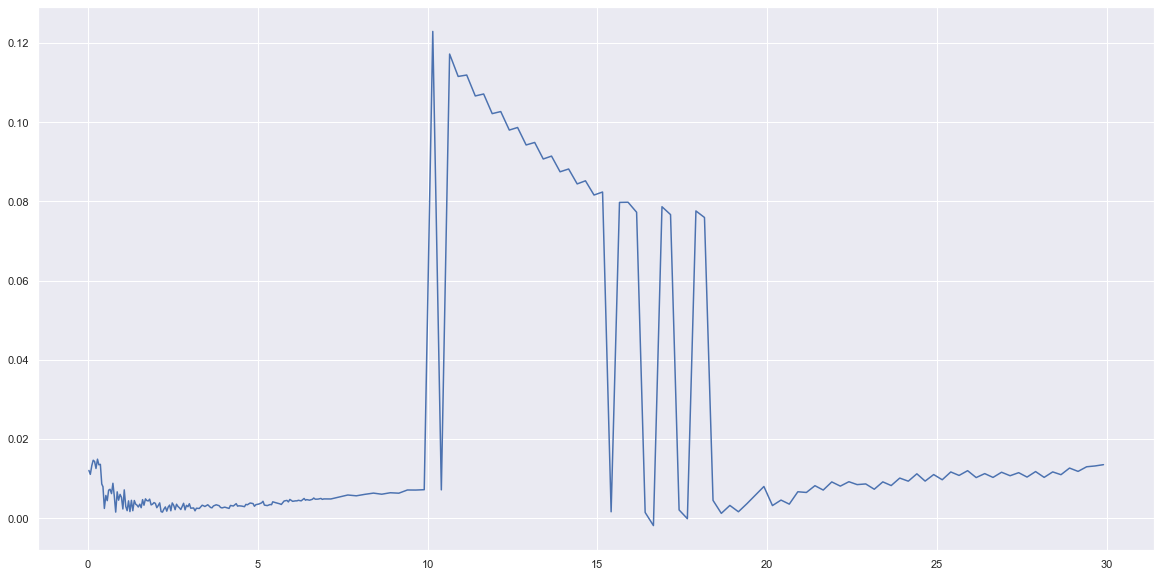

In [71]:
plt.figure(figsize=(20,10))
plt.plot(mat_times, reg_r)